In [1]:
!git clone https://github.com/balajisrinivas/Face-Mask-Detection.git


Cloning into 'Face-Mask-Detection'...
remote: Enumerating objects: 3764, done.
remote: Total 3764 (delta 0), reused 0 (delta 0), pack-reused 3764
Receiving objects: 100% (3764/3764), 143.05 MiB | 26.95 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Checking out files: 100% (3840/3840), done.


In [2]:
!pip3 install tensorflow_gpu

     |████████████████████████████████| 458.3 MB 10 kB/s 


In [4]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

datasetFolder = "/content/Face-Mask-Detection/dataset"
categories = ["with_mask", "without_mask"]

data = []
labels = []

for category in categories:
    path = os.path.join(datasetFolder, category)
    for filename in os.listdir(path):
        imgPath = os.path.join(path, filename)
        img = load_img(imgPath, target_size=(224, 224))
        img = img_to_array(img)
        img = preprocess_input(img)

        data.append(img)
        labels.append(category)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [5]:
print(len(labels))
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
print(len(labels))
# labels = to_categorical(img)
# print(len(labels))


print(len(data))
data = np.array(data)
labels = np.array(labels)

3833
3833
3833


In [6]:
print(data.shape)
print(labels.shape)

(3833, 224, 224, 3)
(3833, 1)


In [7]:
print(data)

[[[[-0.41176468 -0.42745095 -0.31764704]
   [-0.41176468 -0.42745095 -0.31764704]
   [-0.41176468 -0.42745095 -0.31764704]
   ...
   [-0.4352941  -0.4823529  -0.40392154]
   [-0.4352941  -0.4823529  -0.40392154]
   [-0.4352941  -0.4823529  -0.40392154]]

  [[-0.41176468 -0.42745095 -0.31764704]
   [-0.41176468 -0.42745095 -0.31764704]
   [-0.41176468 -0.42745095 -0.31764704]
   ...
   [-0.4352941  -0.4823529  -0.40392154]
   [-0.4352941  -0.4823529  -0.40392154]
   [-0.4352941  -0.4823529  -0.40392154]]

  [[-0.41176468 -0.42745095 -0.31764704]
   [-0.41176468 -0.42745095 -0.31764704]
   [-0.41176468 -0.42745095 -0.31764704]
   ...
   [-0.4352941  -0.4823529  -0.40392154]
   [-0.4352941  -0.4823529  -0.40392154]
   [-0.4352941  -0.4823529  -0.40392154]]

  ...

  [[-0.15294117 -0.05882353  0.03529418]
   [-0.15294117 -0.05882353  0.03529418]
   [-0.15294117 -0.05882353  0.03529418]
   ...
   [-0.5764706  -0.6156863  -0.5686275 ]
   [-0.5764706  -0.6156863  -0.5686275 ]
   [-0.5764706  

In [8]:
print(labels)

[[0]
 [0]
 [0]
 ...
 [1]
 [1]
 [1]]


In [9]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, AveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model

trainX, testX, trainY, testY = train_test_split(data,
                                                labels,
                                                test_size = 0.2,
                                                stratify=labels,
                                                random_state=42)

aug = ImageDataGenerator(
    rotation_range = 20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

baseModel = MobileNetV2(weights='imagenet', include_top=False,
                        input_tensor=Input(shape=(224,224,3)))

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7,7))(headModel)
headModel = Flatten(name='flatten')(headModel)
headModel = Dense(128, activation='relu')(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(1, activation='sigmoid')(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
  layer.trainable = False

print(model.summary())

9420800/9406464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________

In [10]:
from tensorflow.keras.optimizers import Adam

lr = 1e-4
epoch = 20
batchSize = 32

opt = Adam(learning_rate=lr, decay=lr/epoch)
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

history = model.fit(aug.flow(trainX, trainY, batch_size = batchSize),
                    steps_per_epoch = len(trainX) // batchSize,
                    validation_data = (testX, testY),
                    validation_steps = len(testX) // batchSize,
                    epochs = epoch)

Epoch 1/20
95/95 [==============================] - 133s 1s/step - loss: 0.3539 - accuracy: 0.8477 - val_loss: 0.1178 - val_accuracy: 0.9778
Epoch 2/20
95/95 [==============================] - 131s 1s/step - loss: 0.1364 - accuracy: 0.9581 - val_loss: 0.0671 - val_accuracy: 0.9831
Epoch 3/20
95/95 [==============================] - 134s 1s/step - loss: 0.0868 - accuracy: 0.9730 - val_loss: 0.0492 - val_accuracy: 0.9857
Epoch 4/20
95/95 [==============================] - 132s 1s/step - loss: 0.0756 - accuracy: 0.9743 - val_loss: 0.0430 - val_accuracy: 0.9844
Epoch 5/20
95/95 [==============================] - 133s 1s/step - loss: 0.0612 - accuracy: 0.9802 - val_loss: 0.0398 - val_accuracy: 0.9831
Epoch 6/20
95/95 [==============================] - 131s 1s/step - loss: 0.0531 - accuracy: 0.9819 - val_loss: 0.0329 - val_accuracy: 0.9909
Epoch 7/20
95/95 [==============================] - 136s 1s/step - loss: 0.0465 - accuracy: 0.9862 - val_loss: 0.0303 - val_accuracy: 0.9948
Epoch 8/20
95

In [11]:
from sklearn.metrics import classification_report

pred = model.predict(testX, batch_size=batchSize)
print(pred)

pred = np.argmax(pred, axis=1)

print(classification_report(testY, pred,
                            target_names = lb.classes_))

model.save("mask_detector.model", save_format="h5")

[[9.98798370e-01]
 [9.99994636e-01]
 [9.96399045e-01]
 [2.53190994e-02]
 [9.40864993e-06]
 [9.99995947e-01]
 [9.30577517e-04]
 [9.99966204e-01]
 [3.24376051e-05]
 [8.19375038e-01]
 [1.63263083e-03]
 [5.56012128e-06]
 [1.29278898e-02]
 [9.99625444e-01]
 [9.98358846e-01]
 [9.99718189e-01]
 [9.99252796e-01]
 [1.18935736e-06]
 [3.22639942e-04]
 [9.99989152e-01]
 [1.67727470e-03]
 [9.99111295e-01]
 [9.93680060e-01]
 [1.41918659e-04]
 [1.26123428e-04]
 [4.80106391e-05]
 [1.75021887e-02]
 [9.99675989e-01]
 [9.81397390e-01]
 [3.53855669e-01]
 [9.99820948e-01]
 [9.75872815e-01]
 [9.99992132e-01]
 [2.07615017e-06]
 [3.64939624e-05]
 [9.99890089e-01]
 [9.77179646e-01]
 [9.99307632e-01]
 [9.99930799e-01]
 [9.99942422e-01]
 [1.02088443e-05]
 [1.01000398e-06]
 [9.98331368e-01]
 [9.95821595e-01]
 [9.99625802e-01]
 [9.92179215e-01]
 [2.80089648e-06]
 [9.99162734e-01]
 [9.97352004e-01]
 [9.98984814e-01]
 [9.99845862e-01]
 [4.46946433e-06]
 [9.72190380e-01]
 [3.07321548e-04]
 [5.39416797e-05]
 [5.598439

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


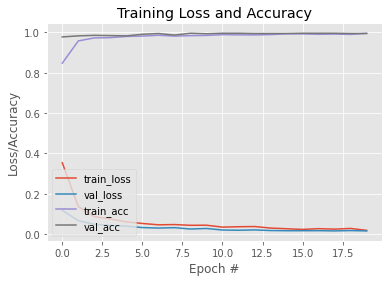

In [12]:
import matplotlib.pyplot as plt

N = epoch
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")